In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [2]:
df = pd.read_csv("vlc_positioning_dataset_2.csv")
df

,X,Y,LED1,LED2,LED3,LED4
0,4.07360,3.72430,0.000088,0.000012,0.000133,0.061205
1,4.52900,4.46130,0.000029,0.000008,0.000064,0.009562
2,0.63493,1.21300,0.018080,0.000016,0.000073,0.000096
3,4.56690,0.64798,0.000162,0.000002,0.002708,0.000281
4,3.16180,1.12530,0.000622,0.000007,0.001737,0.000400
...,...,...,...,...,...,...
1995,0.12575,1.03960,0.004333,0.000012,0.000046,0.000047
1996,2.07210,0.19802,0.001693,0.000005,0.000246,0.000113
1997,3.65700,2.34680,0.000266,0.000011,0.000615,0.001607
1998,3.90690,0.75048,0.000296,0.000003,0.017587,0.000325


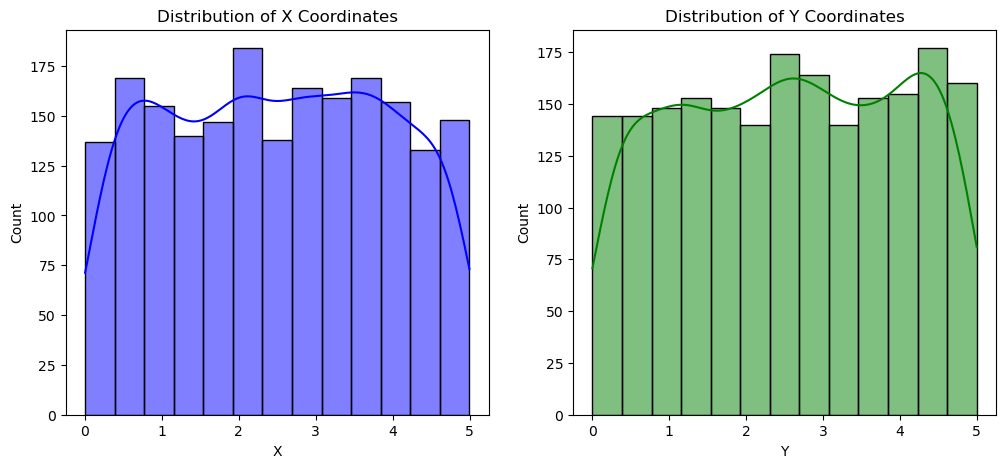

In [3]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['X'], kde=True, color='blue')
plt.title('Distribution of X Coordinates')

plt.subplot(1,2,2)
sns.histplot(df['Y'], kde=True, color='green')
plt.title('Distribution of Y Coordinates')

plt.show();

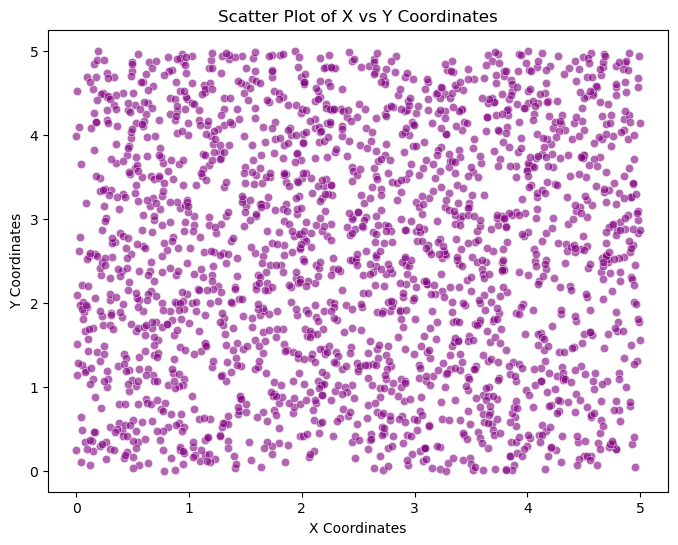

In [4]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['X'], y=df['Y'], alpha=0.6, color='purple')
plt.title('Scatter Plot of X vs Y Coordinates')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.show();

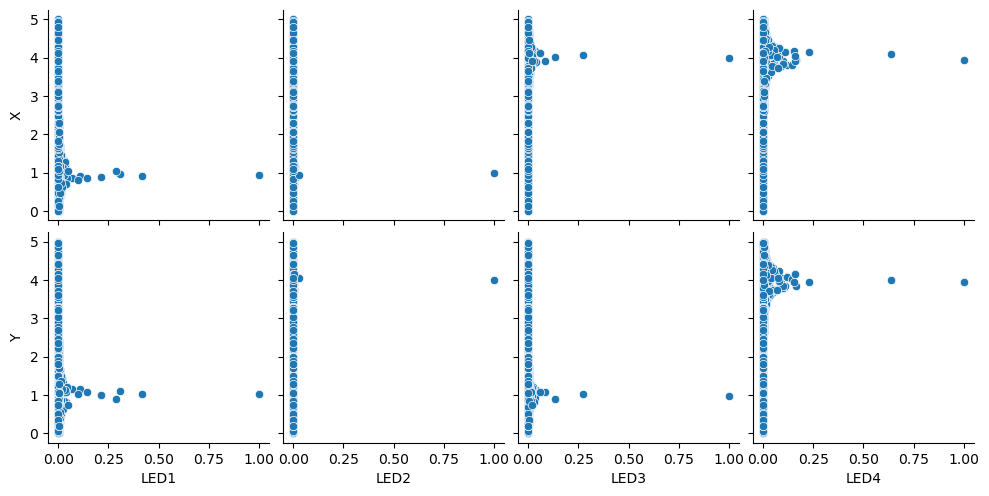

In [5]:
sns.pairplot(df, x_vars=['LED1', 'LED2', 'LED3', 'LED4'], y_vars=['X', 'Y'], kind='scatter')
plt.show();

In [6]:
X = df[['LED1', 'LED2', 'LED3', 'LED4']]
y = df[['X', 'Y']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (1600, 4)
Testing features shape: (400, 4)
Training labels shape: (1600, 2)
Testing labels shape: (400, 2)


In [7]:
from sklearn.multioutput import MultiOutputRegressor

gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

param_grid = {
    'estimator__n_estimators': [50, 100, 200, 300, 400],
    'estimator__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'estimator__max_depth': [3, 5, 7, 9, 11],
    'estimator__min_samples_split': [2, 5, 10, 15, 20],
    'estimator__min_samples_leaf': [1, 2, 4, 6, 8]
}

grid_search = GridSearchCV(estimator=gbr,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 3125 candidates, totalling 15625 fits
Best Hyperparameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__min_samples_leaf': 6, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 400}


In [8]:
best_gbr_estimator = GradientBoostingRegressor(
    n_estimators=best_params['estimator__n_estimators'],
    learning_rate=best_params['estimator__learning_rate'],
    max_depth=best_params['estimator__max_depth'],
    min_samples_split=best_params['estimator__min_samples_split'],
    min_samples_leaf=best_params['estimator__min_samples_leaf'],
    random_state=42
)

best_gbr = MultiOutputRegressor(best_gbr_estimator)

best_gbr.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=7,
                                                         min_samples_leaf=6,
                                                         n_estimators=400,
                                                         random_state=42))

In [9]:
y_pred_gbr = best_gbr.predict(X_test)

mae_x_gbr = mean_absolute_error(y_test['X'], y_pred_gbr[:, 0])
rmse_x_gbr = np.sqrt(mean_squared_error(y_test['X'], y_pred_gbr[:, 0]))
r2_x_gbr = r2_score(y_test['X'], y_pred_gbr[:, 0])

mae_y_gbr = mean_absolute_error(y_test['Y'], y_pred_gbr[:, 1])
rmse_y_gbr = np.sqrt(mean_squared_error(y_test['Y'], y_pred_gbr[:, 1]))
r2_y_gbr = r2_score(y_test['Y'], y_pred_gbr[:, 1])

print(f"Gradient Boosting Model - X Coordinate Metrics:")
print(f"MAE: {mae_x_gbr}")
print(f"RMSE: {rmse_x_gbr}")
print(f"R² Score: {r2_x_gbr}")

print(f"\nGradient Boosting Model - Y Coordinate Metrics:")
print(f"MAE: {mae_y_gbr}")
print(f"RMSE: {rmse_y_gbr}")
print(f"R² Score: {r2_y_gbr}")

Gradient Boosting Model - X Coordinate Metrics:
MAE: 0.020464218468976295
RMSE: 0.02751428206606738
R² Score: 0.9996236728122333

Gradient Boosting Model - Y Coordinate Metrics:
MAE: 0.021275293312982817
RMSE: 0.02848830254404806
R² Score: 0.9996061688492289


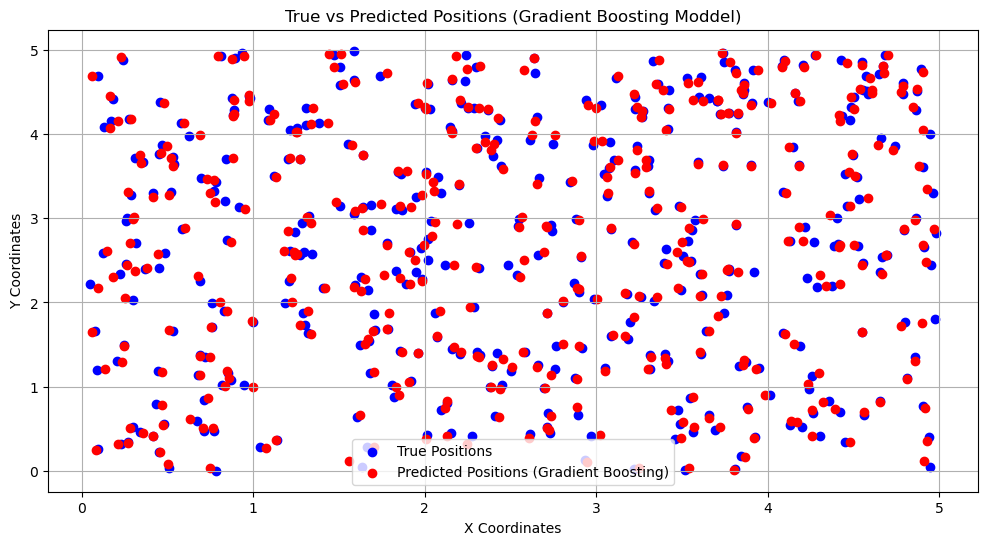

In [10]:
plt.figure(figsize=(12,6))
plt.scatter(y_test['X'], y_test['Y'], color='blue', label='True Positions')
plt.scatter(y_pred_gbr[:, 0], y_pred_gbr[:, 1], color='red', label='Predicted Positions (Gradient Boosting)')
plt.title('True vs Predicted Positions (Gradient Boosting Moddel)')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.legend()
plt.grid(True)
plt.show();

In [11]:
joblib.dump(best_gbr, 'gradient_boosting_position_predictor.pkl')

['gradient_boosting_position_predictor.pkl']

In [12]:
import joblib

loaded_model = joblib.load('tuned_random_forest_position_predictor.pkl')

print(f"Loaded model type: {type(loaded_model)}")

Loaded model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [13]:
new_rss_values = [	
	[8.78E-05,1.22E-05,0.00013303,0.061205],
	[2.89E-05,7.95E-06,6.44E-05,0.0095622],
	[0.01808,1.57E-05,7.30E-05,9.57E-05]
]

predicted_positions = loaded_model.predict(new_rss_values)

print("Predicted Positions (X,Y): ")
print(predicted_positions)

Predicted Positions (X,Y): 
[[4.07227733 3.73145633]
 [4.51328167 4.47317   ]
 [0.63268583 1.20902   ]]


C:\Users\MSII\Desktop\FYP-VLP\RFR_Model\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Example: Evaluate on the test set
y_pred_loaded = loaded_model.predict(X_test)

# Calculate evaluation metrics for X and Y coordinates
mae_x_loaded = mean_absolute_error(y_test['X'], y_pred_loaded[:, 0])
rmse_x_loaded = np.sqrt(mean_squared_error(y_test['X'], y_pred_loaded[:, 0]))
r2_x_loaded = r2_score(y_test['X'], y_pred_loaded[:, 0])

mae_y_loaded = mean_absolute_error(y_test['Y'], y_pred_loaded[:, 1])
rmse_y_loaded = np.sqrt(mean_squared_error(y_test['Y'], y_pred_loaded[:, 1]))
r2_y_loaded = r2_score(y_test['Y'], y_pred_loaded[:, 1])

# Print the metrics
print(f"Loaded Model - X Coordinate Metrics:")
print(f"MAE: {mae_x_loaded}")
print(f"RMSE: {rmse_x_loaded}")
print(f"R² Score: {r2_x_loaded}")

print(f"\nLoaded Model - Y Coordinate Metrics:")
print(f"MAE: {mae_y_loaded}")
print(f"RMSE: {rmse_y_loaded}")
print(f"R² Score: {r2_y_loaded}")

Loaded Model - X Coordinate Metrics:
MAE: 0.020615681574999857
RMSE: 0.037683174232920606
R² Score: 0.9992940983754242

Loaded Model - Y Coordinate Metrics:
MAE: 0.020805866479167327
RMSE: 0.03710607176806504
R² Score: 0.9993318609131993
